# Восстановление золота из руды

Не вдаваясь в тонкости технологического процесса, необходимо подготовить, исследовать данные, построить и обучить модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Модель предполагается использовать, как один из инструментов оптимизации производства.
Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from copy import deepcopy

from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_absolute_error 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [ ]:
pd.set_option('chained_assignment', None)

Данные находятся в трёх файлах:

* gold_recovery_train_new.csv — обучающая выборка;
* gold_recovery_test_new.csv — тестовая выборка;
* gold_recovery_full_new.csv — исходные данные.

In [ ]:
gold_recovery_train_new = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [ ]:
gold_recovery_test_new = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [ ]:
gold_recovery_full_new = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [ ]:
gold_recovery_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [ ]:
gold_recovery_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [ ]:
gold_recovery_full_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

Данные индексируются датой и временем получения информации (признак date). 

In [ ]:
gold_recovery_train_new['date'].value_counts()

2017-04-18 01:59:59    1
2016-02-16 13:00:00    1
2018-05-01 04:59:59    1
2018-03-29 05:59:59    1
2016-08-13 00:59:59    1
                      ..
2016-05-15 00:59:59    1
2016-04-20 17:00:00    1
2017-06-26 18:59:59    1
2017-06-29 06:59:59    1
2017-05-04 14:59:59    1
Name: date, Length: 14149, dtype: int64

In [ ]:
gold_recovery_full_new.duplicated().sum()

0

Явных дубликатов нет.

Целевые признаки:

* rougher.output.recovery - эффективность обогащения чернового концентрата
* final.output.recovery - эффективность обогащения финального концентрата 

### Проверим, что эффективность обогащения, предоставленная в исходных данных,  рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery и найдем MAE между полученными расчётами и значением признака.

Расчет эффективности:


Recovery = (C * (F - T)) / (F * (C - T)) * 100%

где:

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.


In [ ]:
gold_recovery_train_new['rougher.output.recovery_my'] = (
    gold_recovery_train_new['rougher.output.concentrate_au'] * (
    gold_recovery_train_new['rougher.input.feed_au'] - gold_recovery_train_new['rougher.output.tail_au'])) / (
    gold_recovery_train_new['rougher.input.feed_au'] * 
    (gold_recovery_train_new['rougher.output.concentrate_au'] - gold_recovery_train_new['rougher.output.tail_au'])) * 100

In [ ]:
gold_recovery_train_new[['rougher.output.recovery','rougher.output.recovery_my']]

,rougher.output.recovery,rougher.output.recovery_my
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


In [ ]:
mean_absolute_error(gold_recovery_train_new['rougher.output.recovery_my'], gold_recovery_train_new['rougher.output.recovery'])

9.682896147825551e-15

MAE между полученным числом и значением признака стремится к нулю. Делаем вывод, что эффективность обогащения, предоставленная в исходных данных, рассчитана правильно.

### В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса.  Также в тестовом наборе нет целевых признаков.

### Предобработка данных.

Учитывая, что в выборках присутствуют пропуски, проведем предобработку выборок, необходимых для дальнейшего исследования.

In [ ]:
for col in col_test: # заменим пропуски на медианные значения
    if gold_recovery_train_new[col].isna().sum() > 0:
        gold_recovery_train_new[col] = gold_recovery_train_new[col].fillna(gold_recovery_train_new[col].median())
    if gold_recovery_full_new[col].isna().sum() > 0:
        gold_recovery_full_new[col] = gold_recovery_full_new[col].fillna(gold_recovery_full_new[col].median())    

## Анализ данных

### Рассмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

#### Au - Золото

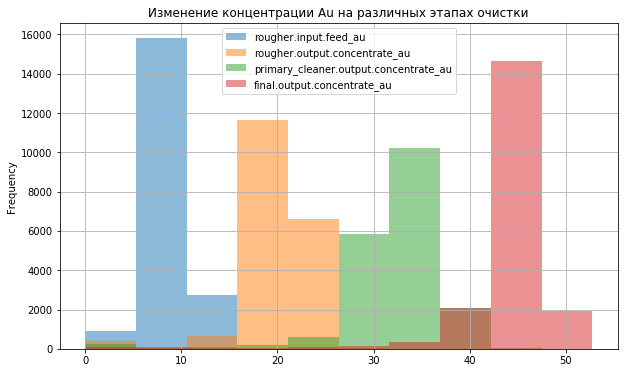

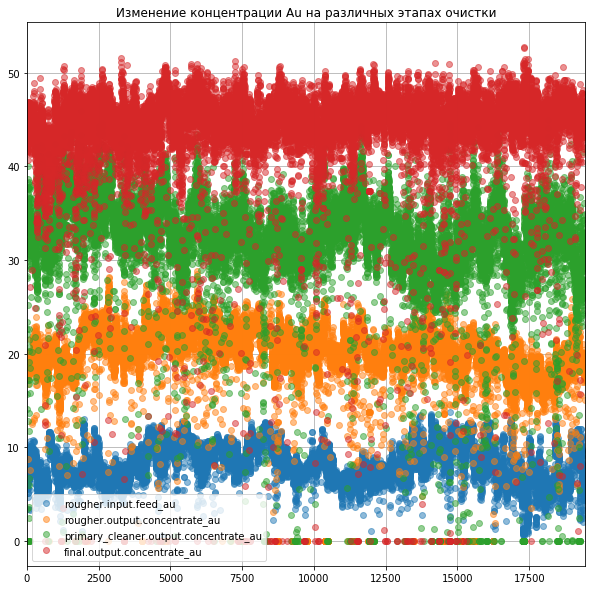

In [ ]:
gold_recovery_full_new[['rougher.input.feed_au',
                        'rougher.output.concentrate_au', 
                        'primary_cleaner.output.concentrate_au', 
                        'final.output.concentrate_au']].plot(
    title='Изменение концентрации Au на различных этапах очистки',
    kind='hist',
    grid=True, 
    figsize=(10, 6),
    alpha=0.5
)

gold_recovery_full_new[['rougher.input.feed_au',
                        'rougher.output.concentrate_au', 
                        'primary_cleaner.output.concentrate_au', 
                        'final.output.concentrate_au']].plot(
    title='Изменение концентрации Au на различных этапах очистки',
    style='o',
    grid=True, 
    figsize=(10, 10),
    alpha=0.5
)      

#### Ag - серебро

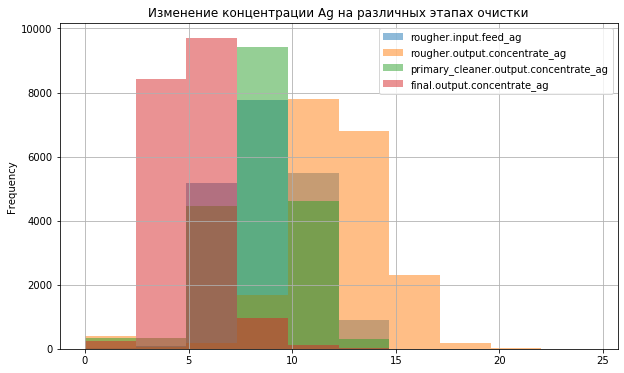

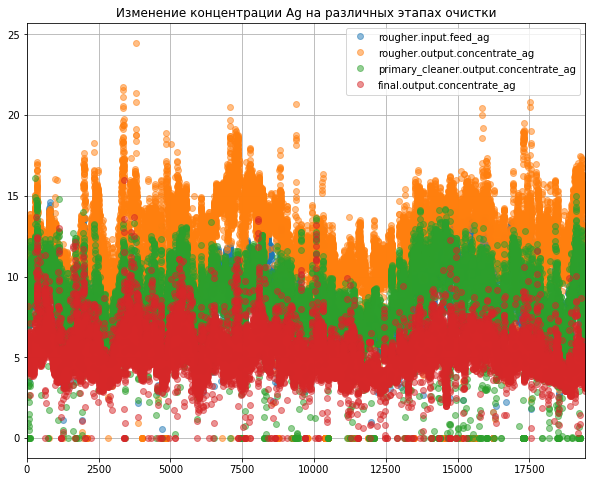

In [ ]:
gold_recovery_full_new[['rougher.input.feed_ag',
                        'rougher.output.concentrate_ag', 
                        'primary_cleaner.output.concentrate_ag', 
                        'final.output.concentrate_ag']].plot(
    title='Изменение концентрации Ag на различных этапах очистки',
    kind='hist',
    grid=True, 
    figsize=(10, 6),
    alpha=0.5
)

gold_recovery_full_new[['rougher.input.feed_ag',
                        'rougher.output.concentrate_ag', 
                        'primary_cleaner.output.concentrate_ag', 
                        'final.output.concentrate_ag']].plot(
    title='Изменение концентрации Ag на различных этапах очистки',
    style='o',
    grid=True, 
    figsize=(10, 8),
    alpha=0.5
)

#### Pb - свинец

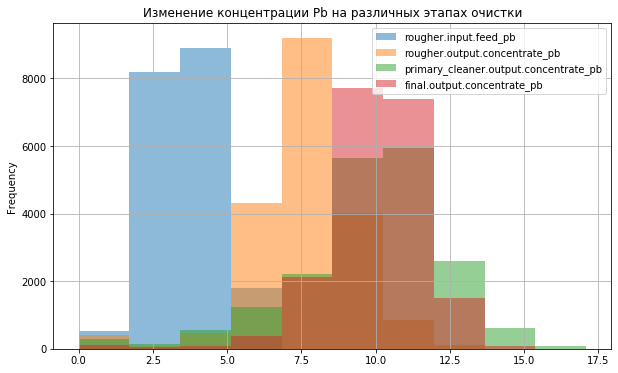

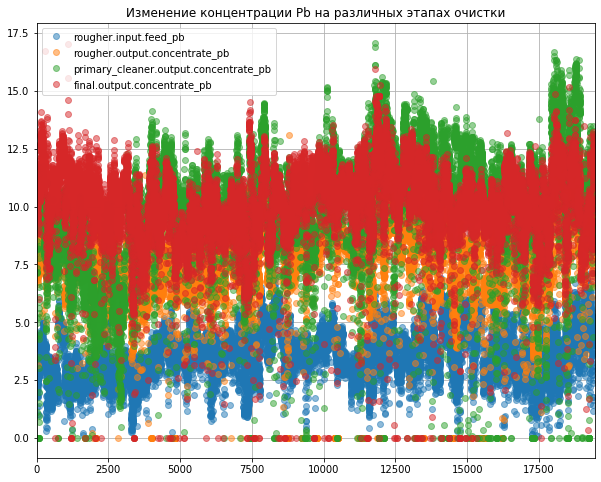

In [ ]:
gold_recovery_full_new[['rougher.input.feed_pb',
                        'rougher.output.concentrate_pb', 
                        'primary_cleaner.output.concentrate_pb', 
                        'final.output.concentrate_pb']].plot(
    title='Изменение концентрации Pb на различных этапах очистки',
    kind='hist',
    grid=True, 
    figsize=(10, 6),
    alpha=0.5
)

gold_recovery_full_new[['rougher.input.feed_pb',
                        'rougher.output.concentrate_pb', 
                        'primary_cleaner.output.concentrate_pb', 
                        'final.output.concentrate_pb']].plot(
    title='Изменение концентрации Pb на различных этапах очистки',
    style='o',
    grid=True, 
    figsize=(10, 8),
    alpha=0.5
)

Концентрация золота логично увеличивается к финальному этапу. 

Концентрация серебра - уменьшается, а концентрация свинца - увеличивается, вероятно это связано с химическими процессами, используемыми при получении золота из руды.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6ac6b3f50>,
      dtype=object)

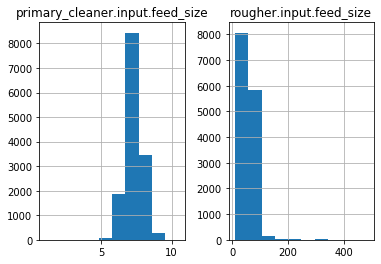

In [ ]:
gold_recovery_train_new[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6b67ae110>,
      dtype=object)

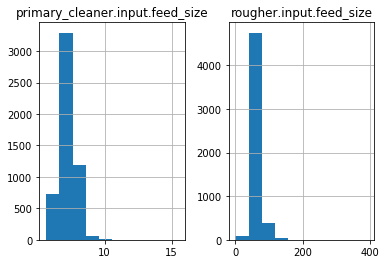

In [ ]:
gold_recovery_test_new[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']].hist()

Распределения размеров гранул сырья на обучающей и тестовой выборках совсем немного отличаются, в целом размеры большинства частиц лежат в идентичных интервалах. Выборки подходят для использования, оценка модели должна получиться адекватной.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
gold_recovery_train_new['rougher_sum_concentrate'] = gold_recovery_train_new[
    'rougher.output.concentrate_au'] + gold_recovery_train_new[
    'rougher.output.concentrate_ag'] + gold_recovery_train_new[
    'rougher.output.concentrate_pb'] + gold_recovery_train_new[
    'rougher.output.concentrate_sol']

gold_recovery_full_new['rougher_sum_concentrate'] = gold_recovery_full_new[
    'rougher.output.concentrate_au'] + gold_recovery_full_new[
    'rougher.output.concentrate_ag'] + gold_recovery_full_new[
    'rougher.output.concentrate_pb'] + gold_recovery_full_new[
    'rougher.output.concentrate_sol']

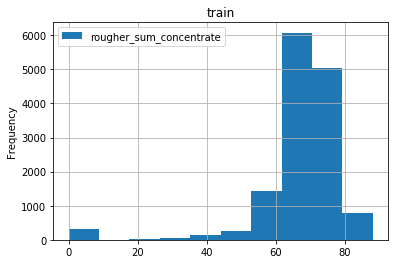

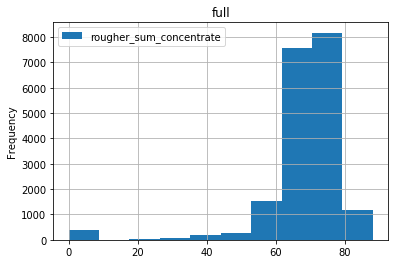

In [ ]:
gold_recovery_train_new['rougher_sum_concentrate'].plot(kind='hist', grid=True, title='train', legend=True)
plt.show()
gold_recovery_full_new['rougher_sum_concentrate'].plot(kind='hist', grid=True, title='full', legend=True)

In [ ]:
gold_recovery_train_new[gold_recovery_train_new['rougher_sum_concentrate'] == 0]['rougher_sum_concentrate'].count()

297

In [ ]:
gold_recovery_full_new[gold_recovery_full_new['rougher_sum_concentrate'] == 0]['rougher_sum_concentrate'].count()

394

In [ ]:
gold_recovery_train_new['primary_cleaner_sum_concentrate'] = gold_recovery_train_new[
    'primary_cleaner.output.concentrate_au'] + gold_recovery_train_new[
    'primary_cleaner.output.concentrate_ag'] + gold_recovery_train_new[
    'primary_cleaner.output.concentrate_pb'] + gold_recovery_train_new[
    'primary_cleaner.output.concentrate_sol']

gold_recovery_full_new['primary_cleaner_sum_concentrate'] = gold_recovery_full_new[
    'primary_cleaner.output.concentrate_au'] + gold_recovery_full_new[
    'primary_cleaner.output.concentrate_ag'] + gold_recovery_full_new[
    'primary_cleaner.output.concentrate_pb'] + gold_recovery_full_new[
    'primary_cleaner.output.concentrate_sol']

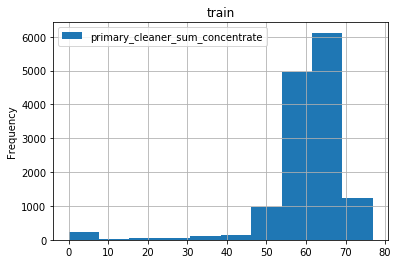

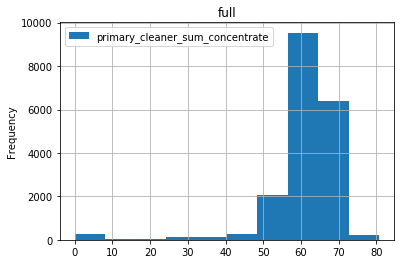

In [ ]:
gold_recovery_train_new['primary_cleaner_sum_concentrate'].plot(kind='hist', grid=True, title='train', legend=True)
plt.show()
gold_recovery_full_new['primary_cleaner_sum_concentrate'].plot(kind='hist', grid=True, title='full', legend=True)

In [ ]:
gold_recovery_train_new[gold_recovery_train_new[
    'primary_cleaner_sum_concentrate'] == 0]['primary_cleaner_sum_concentrate'].count()

74

In [ ]:
gold_recovery_full_new[gold_recovery_full_new[
    'primary_cleaner_sum_concentrate'] == 0]['primary_cleaner_sum_concentrate'].count()

108

In [ ]:
gold_recovery_train_new['final_sum_concentrate'] = gold_recovery_train_new[
    'final.output.concentrate_au'] + gold_recovery_train_new[
    'final.output.concentrate_ag'] + gold_recovery_train_new[
    'final.output.concentrate_pb'] + gold_recovery_train_new[
    'final.output.concentrate_sol']

gold_recovery_full_new['final_sum_concentrate'] = gold_recovery_full_new[
    'final.output.concentrate_au'] + gold_recovery_full_new[
    'final.output.concentrate_ag'] + gold_recovery_full_new[
    'final.output.concentrate_pb'] + gold_recovery_full_new[
    'final.output.concentrate_sol']

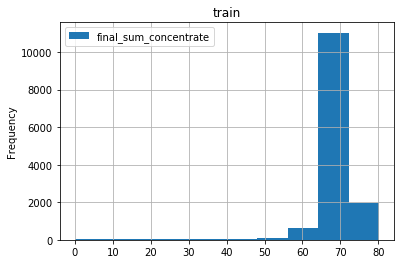

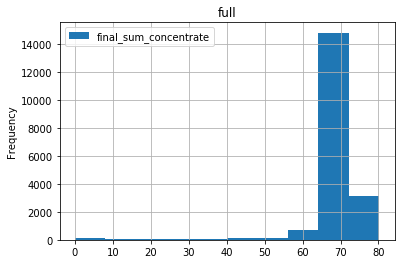

In [ ]:
gold_recovery_train_new['final_sum_concentrate'].plot(kind='hist', grid=True, title='train', legend=True)
plt.show()
gold_recovery_full_new['final_sum_concentrate'].plot(kind='hist', grid=True, title='full', legend=True)

In [ ]:
gold_recovery_train_new[gold_recovery_train_new['final_sum_concentrate'] == 0]['final_sum_concentrate'].count()

58

In [ ]:
gold_recovery_full_new[gold_recovery_full_new['final_sum_concentrate'] == 0]['final_sum_concentrate'].count()

98

Исследуя суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, выявлены аномальные значения - нулевые значения суммарной концентрации, т.е. совершенно пустая порода, значит большая вероятность неточности вычислений либо человеческий фактор. Чтобы снизить ошибку удалим строки с нулевыми значениями суммарной концентрации в сырье из обучающей и из исходной выборок.

In [ ]:
gold_recovery_train_new.shape

(14149, 91)

In [ ]:
gold_recovery_train_new = gold_recovery_train_new.drop(
    gold_recovery_train_new[gold_recovery_train_new['rougher_sum_concentrate'] == 0].index, axis=0)

In [ ]:
gold_recovery_train_new.shape

(13852, 91)

In [ ]:
gold_recovery_full_new.shape

(19439, 90)

In [ ]:
gold_recovery_full_new = gold_recovery_full_new.drop(
    gold_recovery_full_new[gold_recovery_full_new['rougher_sum_concentrate'] == 0].index, axis=0)

In [ ]:
gold_recovery_full_new.shape

(19045, 90)

## Модель

Обучающая выборка для модели:

In [ ]:
features_train = deepcopy(gold_recovery_train_new[col_test]) # выберем столбцы для обучающей выборки, как в тестовой

In [ ]:
features_train = features_train.drop(['date'], axis=1) # извлечем признаки, обучающая выборка 

In [ ]:
features_train.shape

(13852, 52)

In [ ]:
target_train = deepcopy(gold_recovery_train_new[['rougher.output.recovery','final.output.recovery']]) # целевые признаки, обучающая выборка

In [ ]:
target_train.shape

(13852, 2)

Тестовая выборка для модели:

Целевые признаки для тестовой выборки возьмем из исходных данных по датам-индексам.

In [ ]:
date_test = gold_recovery_test_new['date']

In [ ]:
date_test

0       2016-09-01 00:59:59
1       2016-09-01 01:59:59
2       2016-09-01 02:59:59
3       2016-09-01 03:59:59
4       2016-09-01 04:59:59
               ...         
5285    2017-12-31 19:59:59
5286    2017-12-31 20:59:59
5287    2017-12-31 21:59:59
5288    2017-12-31 22:59:59
5289    2017-12-31 23:59:59
Name: date, Length: 5290, dtype: object

In [ ]:
features_test = gold_recovery_full_new.query('date in @date_test')[col_test].reset_index(drop=True)  
# строим срез, в котором значения столбца date равны значениям date_test 
# и выбираем все столбцы, как в gold_recovery_test_new

In [ ]:
features_test = features_test.drop(['date'], axis=1) # извлечем признаки, тестовая выборка 

In [ ]:
features_test.shape

(5193, 52)

In [ ]:
target_test = gold_recovery_full_new.query(
    'date in @date_test')[['rougher.output.recovery','final.output.recovery']].reset_index(drop=True)  
# строим срез, в котором значения столбца date равны значениям date_test 

In [ ]:
target_test.shape

(5193, 2)

In [ ]:
target_test

,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5188,95.172585,68.919891
5189,94.575036,68.440582
5190,93.018138,67.092759
5191,92.599042,68.061186


### Функция для вычисления итоговой sMAPE.

In [ ]:
def sMAPE(target, predicted):
    a = abs(target - predicted) / ((abs(target) + abs(predicted)) / 2)
    a = a.sum() / len(target) * 100
    return a

In [ ]:
def total_sMAPE(final_scoreR, final_scoreF):
    return final_scoreR * 0.25 + final_scoreF * 0.75

In [ ]:
scoring = make_scorer(sMAPE, greater_is_better=True) # scoring=scoring для cross_val_score

In [ ]:
def sMAPE_cross_val_score(model, features, target, scoring, cv):
    
    scoresR = cross_val_score(model, 
                              features, 
                              target['rougher.output.recovery'], 
                              scoring=scoring, 
                              cv=cv) 
    
    scoresF = cross_val_score(model, 
                              features, 
                              target['final.output.recovery'], 
                              scoring=scoring, 
                              cv=cv) 
    
    final_scoreR = sum(scoresR) / cv
    final_scoreF = sum(scoresF) / cv
    
    return total_sMAPE(final_scoreR, final_scoreF)


### Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. 

In [ ]:
data = []
col = ['model', 'best_score', 'depth', 'est']

In [ ]:
best_modelDTR = None
best_depthDTR = 0
best_scoreDTR = 100

for depth in range(1, 5): # в цикле меняем гиперпараметр - максимальную глубину дерева

    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) # модель - дерево решений, с заданной глубиной дерева
    
    score = sMAPE_cross_val_score(model, features_train, target_train, scoring, 5)
    
    if score < best_scoreDTR:
        best_modelDTR = model
        best_depthDTR = depth
        best_scoreDTR = score

print("Итоговое sMAPE лучшей модели 'Дерево решений' на обучающей выборке:", best_scoreDTR, "Глубина дерева:", best_depthDTR)

data.append(['DecTreeRegressor', best_scoreDTR, best_depthDTR, '-'])      

Итоговое sMAPE лучшей модели 'Дерево решений' на обучающей выборке: 9.805468650678913 Глубина дерева: 3


In [ ]:
best_modelRFR = None
best_depthRFR = 0
best_est = 0
best_scoreRFR = 100

for est in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 7): # в цикле меняем гиперпараметр - максимальную глубину дерева

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # случайный лес

        score = sMAPE_cross_val_score(model, features_train, target_train, scoring, 5)
        
        if score < best_scoreRFR:
            best_modelRFR = model
            best_depthRFR = depth
            best_est = est
            best_scoreRFR = score

print("Итоговое sMAPE лучшей модели 'Случайный лес' на обучающей выборке:", best_scoreRFR, "Глубина дерева:", best_depthRFR, "Количество деревьев:", best_est)

data.append(['RandForRegressor', best_scoreRFR, best_depthRFR, best_est])        

Итоговое sMAPE лучшей модели 'Случайный лес' на обучающей выборке: 9.337000005780538 Глубина дерева: 5 Количество деревьев: 9


In [ ]:
modelLinR = LinearRegression() # инициализируем модель LinearRegression

score = sMAPE_cross_val_score(modelLinR, features_train, target_train, scoring, 5)

print("Итоговое sMAPE модели 'Линейная регрессия' на обучающей выборке:", score)

data.append(['LinearRegression', score, '-', '-'])      

Итоговое sMAPE модели 'Линейная регрессия' на обучающей выборке: 11.376283048887293


Создадим константную модель для проверки качества моделей и выбора лучшей модели. Константную модель выберем следующую: каждому объекту она прогнозирует медианное значение целевого признака обучающей выборки.

In [ ]:
predicted_const_R = pd.Series(
    target_train['rougher.output.recovery'].median(), index=target_train['rougher.output.recovery'].index)

In [ ]:
predicted_const_F = pd.Series(
    target_train['final.output.recovery'].median(), index=target_train['final.output.recovery'].index)

Оценка на константной модели для обучающей выборки:

In [ ]:
score = total_sMAPE(sMAPE(target_train['rougher.output.recovery'], predicted_const_R), 
            sMAPE(target_train['final.output.recovery'], predicted_const_F))

print("Итоговое sMAPE константной модели на обучающей выборке:", score)

data.append(['-', '-', '-', '-'])
data.append(['ConstModel train', score, '-', '-']) 
data.append(['-', '-', '-', '-'])

Итоговое sMAPE константной модели на обучающей выборке: 10.059844879021826


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,best_score,depth,est
0,DecTreeRegressor,9.80547,3,-
1,RandForRegressor,9.337,5,9
2,LinearRegression,11.3763,-,-
3,-,-,-,-
4,ConstModel train,10.0598,-,-
5,-,-,-,-


Лучшая модель на обучающей выборке RandForRegressor. 

Итоговое sMAPE лучшей модели 'Случайный лес' на обучающей выборке: 9.337000005780538 Глубина дерева: 5 Количество деревьев: 9.

Итоговое sMAPE константной модели на обучающей выборке: 10.059844879021826.

Проверим на тестовой выборке все три модели и сравним с оценкой на константной модели для тестовой выборки.

In [ ]:
score = sMAPE_cross_val_score(best_modelDTR, features_test, target_test, scoring, 5)

print("Итоговое sMAPE лучшей модели 'Дерево решений' на тестовой выборке:", score, "Глубина дерева:", best_depthDTR)

data.append(['best_modelDTR test', score, best_depthDTR, '-']) 

Итоговое sMAPE лучшей модели 'Дерево решений' на тестовой выборке: 8.725691953407235 Глубина дерева: 3


In [ ]:
score = sMAPE_cross_val_score(best_modelRFR, features_test, target_test, scoring, 5)

print("Итоговое sMAPE лучшей модели 'Случайный лес' на тестовой выборке:", score)

data.append(['best_modelRFR test', score, best_depthRFR, best_est]) 

Итоговое sMAPE лучшей модели 'Случайный лес' на тестовой выборке: 9.693075022867534


In [ ]:
score = sMAPE_cross_val_score(modelLinR, features_test, target_test, scoring, 5)

print("Итоговое sMAPE модели 'Линейная регрессия' на тестовой выборке:", score)

data.append(['model LinR test', score, '-', '-']) 

Итоговое sMAPE модели 'Линейная регрессия' на тестовой выборке: 9.272809928018567


Оценка на константной модели для тестовой выборки:

In [ ]:
predicted_const_R = pd.Series(
    target_train['rougher.output.recovery'].median(), index=target_train['rougher.output.recovery'].index)

In [ ]:
predicted_const_F = pd.Series(
    target_train['final.output.recovery'].median(), index=target_train['final.output.recovery'].index)

In [ ]:
score = total_sMAPE(sMAPE(target_test['rougher.output.recovery'], predicted_const_R), 
            sMAPE(target_test['final.output.recovery'], predicted_const_F))

print("Итоговое sMAPE константной модели train на тестовой выборке:", score)

data.append(['-', '-', '-', '-'])
data.append(['ConstModel_train test', score, '-', '-']) 

Итоговое sMAPE константной модели train на тестовой выборке: 8.431265564023752


In [ ]:
result = pd.DataFrame(data=data , columns=col) # таблица с результатами

In [ ]:
result

,model,best_score,depth,est
0,DecTreeRegressor,9.805469,3,-
1,RandForRegressor,9.339193,5,9
2,LinearRegression,11.376283,-,-
3,-,-,-,-
4,ConstModel train,10.059845,-,-
5,-,-,-,-
6,best_modelDTR test,8.725692,3,-
7,best_modelRFR test,9.698639,5,9
8,model LinR test,9.27281,-,-
9,-,-,-,-


Лучшая модель на тестовой выборке best_modelDTR test. 
Итоговое sMAPE лучшей модели 'Дерево решений' на тестовой выборке: 8.725691953407235 Глубина дерева: 3. Полученная оценка чуть хуже оценки на константной модели. 

Итоговое sMAPE константной модели на тестовой выборке: 8.431265564023752

Модель, лучшая на обучающей выборке, на тестовой показала приемлемые результаты, оценка меньше 10%.

**Общий вывод**

* Целевые признаки:

* * rougher.output.recovery - эффективность обогащения чернового концентрата

* * final.output.recovery - эффективность обогащения финального концентрата

* MAE между расчётами и значением признака стремится к нулю. Делаем вывод, что эффективность обогащения рассчитана правильно.

* В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса.  Также в тестовом наборе нет целевых признаков.

* Концентрация золота логично увеличивается к финальному этапу. Концентрация серебра - уменьшается, а концентрация свинца - увеличивается, вероятно это связано с химическими процессами, используемыми при получении золота из руды.

* Распределения размеров гранул сырья на обучающей и тестовой выборках совсем немного отличаются, в целом размеры большинства частиц лежат в идентичных интервалах. Выборки подходят для использования, оценка модели должна получиться адекватной.

* Исследуя суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, выявлены аномальные значения - нулевые значения суммарной концентрации, т.е. совершенно пустая порода, ошибки измерений либо человеческий фактор. Чтобы снизить ошибку удалим строки с нулевыми значениями суммарной концентрации в сырье из обучающей и из исходной выборок.

* Итоговое sMAPE лучшей модели 'Случайный лес' на обучающей выборке: 9.337000005780538 Глубина дерева: 5 Количество деревьев: 9.

* Итоговое sMAPE константной модели на обучающей выборке: 10.059844879021826.

* Итоговое sMAPE лучшей модели 'Дерево решений' на тестовой выборке: 8.725691953407235 Глубина дерева: 3. Полученная оценка чуть хуже оценки на константной модели. 

* Итоговое sMAPE константной модели на тестовой выборке: 8.431265564023752

* Модель, лучшая на обучающей выборке, на тестовой показала приемлемые результаты, оценка меньше 10%.
